# Описание проекта

Необходимо провести исследование и ответить на вопрос, как можно оптимизировать маркетинговые затраты.
В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

**Необходимо изучить**:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

# Итоги проекта

Проведен анализ данных от Яндекс.Афиши целью оптимизации маркетинговых затрат. Рассчитаны метрики LTV, CAC, Retention rate, DAU, WAU, MAU, ROMI. Выявлены самые популярные источники траффика, определена окупаемость источников, выявлены особенности поведения пользователей разных когорт в разные периоды времени. Зная информацию, полученную из исследования, можно провести ретроспективный анализ и понять, какие в каждый момент времени проводились маркетинговые активности, оценить их влияние и возможность применять их в будущем. 

# Оглавление
1. [Загрузка данных и подготовка к анализу](#header_1)
2. [Построение отчётов и расчет метрик](#header_2)
    * [Продукт](#header_2_1)
        - [Количество пользователей в день, неделю, месяц](#header_2_1_1)
        - [Количество сессий в день](#header_2_1_2)
        - [Продолжительность сессии](#header_2_1_3)
        - [Возвращаемость](#header_2_1_4)
    * [Продажи](#header_2_2)
        - [Момент совершения первой покупки (Когда люди начинают покупать?)](#header_2_2_1)
        - [Количество совершенных покупок за период (Сколько раз покупают за период?)](#header_2_2_2)
        - [Cредний чек](#header_2_2_3)
        - [LTV](#header_2_2_4)
    * [Маркетинг](#header_2_3)
        - [Сколько денег потратили? Всего / на каждый источник / по времени](#header_2_3_1)
        - [Стоимость привлечения одного покупателя из каждого источника](#header_2_3_2)
        - [Окупаемость расходов (ROI)](#header_2_3_3)
3.  [Вывод](#header_3)

# 1. Загрузка данных и подготовка к анализу <a id="header_1"></a>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
#получение информации по данным, которые хранятся в датасете
def df_wide_info(df):
    print('Информация о датасете:')
    df.info()
    print('')
    print('Количество пропусков по каждому из полей:')
    print(df.isna().sum())
    print('')
    print('Количество полных дублей:')
    print(df.duplicated().sum())
    print('')
    print('Наименования полей:')
    print(df.columns)

Рассмотрим, что хранится в каждом из датасетов.

### Лог сервера с информацией о посещениях сайта

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [4]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
df_wide_info(visits)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Количество пропусков по каждому из полей:
Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

Количество полных дублей:
0

Наименования полей:
Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')


Пропуски отсутствуют. Полные дубли отсутствуют. Нужно привести названия полей к нижнему регистру и избвиться от пробелов.

In [6]:
visits.columns = visits.columns.str.lower()
visits.rename(columns = {'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts'}, inplace = True)
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Стоит посмотреть, какие значения содержит каждый из смысловых атрибутов: есть ли опечатки, ошибки и пр.

In [7]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [8]:
sorted(visits['source_id'].unique())

[1, 2, 3, 4, 5, 6, 7, 9, 10]

Ошибки отсутствуют. 

Приведем поля "дата и время начала сессии", "дата и время окончания сессии" к типу данных datetime.

In [9]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

#проверка приведения типов данных
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### Информация о заказах

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

In [10]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [11]:
df_wide_info(orders)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Количество пропусков по каждому из полей:
Buy Ts     0
Revenue    0
Uid        0
dtype: int64

Количество полных дублей:
0

Наименования полей:
Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


Пропуски отсутствуют. Полные дубли отсутствуют. Нужно привести названия полей к нижнему регистру и избвиться от пробелов.

In [12]:
orders.columns = orders.columns.str.lower()
orders.rename(columns = {'buy ts':'buy_ts'}, inplace = True)
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

Приведем поле "дата и время заказа" к типу данных datetime.

In [13]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
#проверка приведения типов данных
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


### Информация о затратах на маркетинг:
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

In [14]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [15]:
df_wide_info(costs)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

Количество пропусков по каждому из полей:
source_id    0
dt           0
costs        0
dtype: int64

Количество полных дублей:
0

Наименования полей:
Index(['source_id', 'dt', 'costs'], dtype='object')


Пропуски отсутствуют. Полные дубли отсутствуют. Названия полей в норме. 

Стоит посмотреть, какие значения содержит каждый из смысловых атрибутов: есть ли опечатки, ошибки и пр.

In [16]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

Приведем поле "дата" к типу данных datetime.

In [17]:
costs['dt'] = pd.to_datetime(costs['dt'])

#проверка приведения типов данных
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


## Итог

Привели названия полей каждого датасета в удобный для дальнейшей работы вид. Привели поля с датой и временем к нужному типу. 

Описание данных после обработки:

**Лог сервера с информацией о посещениях сайта — `visits`**

поле | описание
---- | -------- 
uid | уникальный идентификатор пользователя
device | категория устройства пользователя
start_ts | дата и время начала сессии
end_ts | дата и время окончания сессии
source_id | идентификатор рекламного источника, из которого пришел пользователь

**Информация о заказах — `orders`**

поле | описание
---- | -------- 
uid | уникальный id пользователя, который сделал заказ
buy_ts | дата и время заказа
revenue | выручка Яндекс.Афиши с этого заказа

**Информация о затратах на маркетинг — `costs`**

поле | описание
---- | -------- 
source_id | идентификатор рекламного источника
dt | дата
costs | затраты на этот рекламный источник в этот день


В логах есть инфорация о 9 рекламных источниках. При этом в логах с сервера о посещениях есть рекламные источники, для которых нет информации о затратах. Есть информация только о двух типах устройств: touch, desktop. 

# 2. Построение отчётов и расчет метрик <a id="header_2"></a>

## 2.1. Продукт <a id="header_2_1"></a>

### 2.1.1. Количество пользователей в день, неделю, месяц<a id="header_2_1_1"></a>

Рассмотрим уникальных пользователей за день, неделю и месяц.
Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [18]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Посчитаем метрики и найдем их средние значения: daily active users (DAU), weekly active users (WAU), monthly active users (MAU). 
Для этого сгруппируем данные по уникальным пользователям.

In [19]:
#средний DAU
dau_mean = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
#средний WAU
wau_mean = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
#средний MAU
mau_mean = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()

In [20]:
print('Средний DAU: {:.0f} уникальных пользователей'.format(dau_mean['uid']))
print('Средний WAU: {:.0f} уникальных пользователей'.format(wau_mean['uid']))
print('Средний MAU: {:.0f} уникальных пользователей'.format(mau_mean['uid']))

Средний DAU: 908 уникальных пользователей
Средний WAU: 5716 уникальных пользователей
Средний MAU: 23228 уникальных пользователей


Можно посчитать регулярность пользования сервисом — то, как часто пользователи к нему обращаются. Для этого необходимо посмотреть на отношения `DAU/WAU` и `DAU/MAU` (sticky factor)

In [21]:
#отношение активынх пользователей за день к активным пользвователям за неделю
sticky_factor = dau_mean/wau_mean
print('{:.2%}'.format(sticky_factor['uid']))

15.88%


In [22]:
#отношение активынх пользователей за день к активным пользвователям за месяц
sticky_factor = dau_mean/mau_mean
print('{:.2%}'.format(sticky_factor['uid']))

3.91%


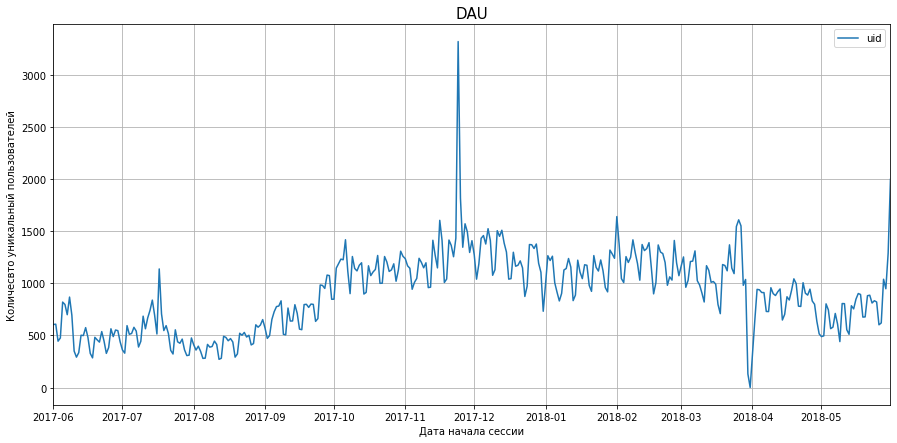

In [23]:
#DAU
visits.groupby('session_date').agg({'uid':'nunique'}).plot(figsize = (15,7), grid = True)
plt.title('DAU', size = 15)
plt.xlabel('Дата начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

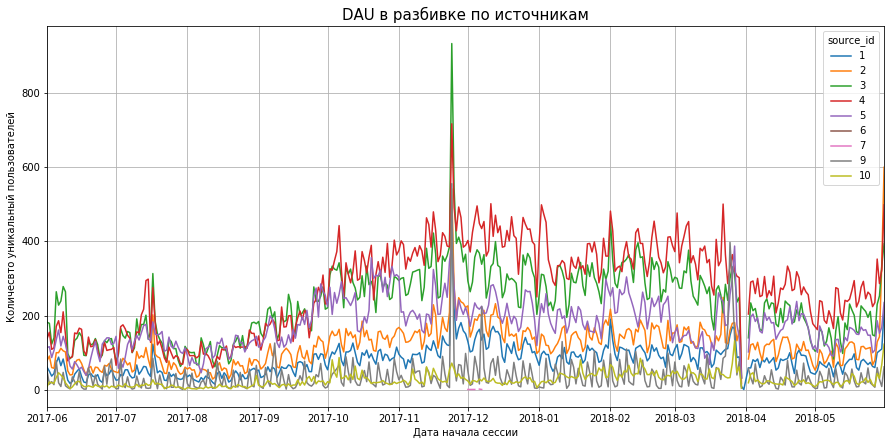

In [24]:
#DAU по источникам
visits.pivot_table(index = 'session_date', 
                   columns = 'source_id', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15,7), grid = True)
plt.title('DAU в разбивке по источникам', size = 15)
plt.xlabel('Дата начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

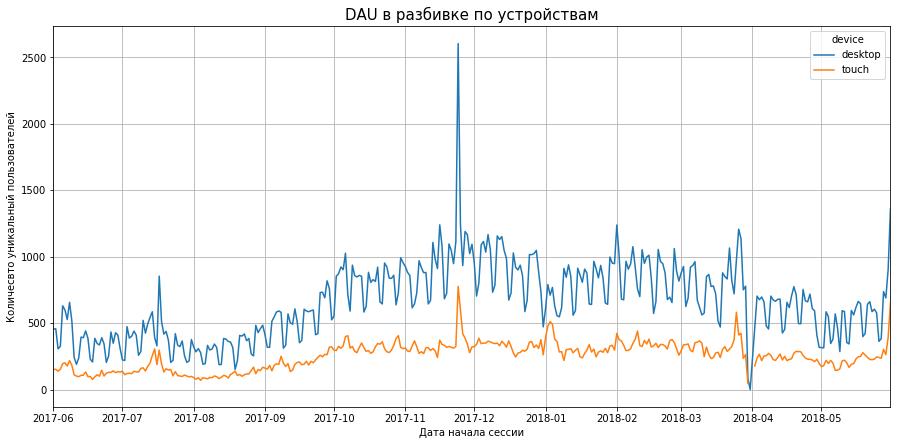

In [25]:
#DAU по устройствам
visits.pivot_table(index = 'session_date', 
                   columns = 'device', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15,7), grid = True)
plt.title('DAU в разбивке по устройствам', size = 15)
plt.xlabel('Дата начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

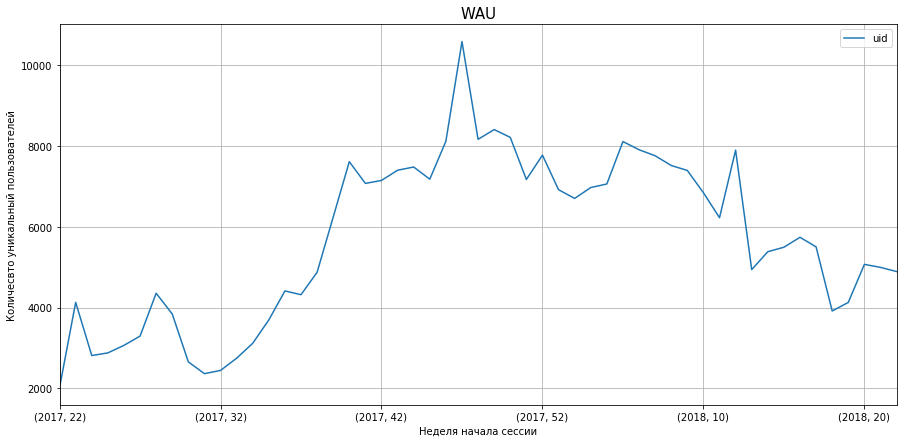

In [26]:
#WAU
visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).plot(figsize = (15,7), grid = True)
plt.title('WAU', size = 15)
plt.xlabel('Неделя начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

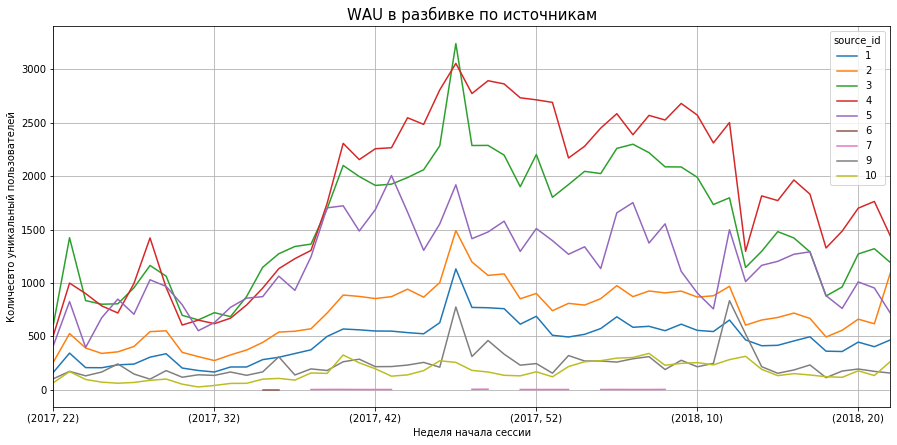

In [27]:
#WAU по источникам
visits.pivot_table(index = ['session_year', 'session_week'], 
                   columns = 'source_id', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15,7), grid = True)
plt.title('WAU в разбивке по источникам', size = 15)
plt.xlabel('Неделя начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

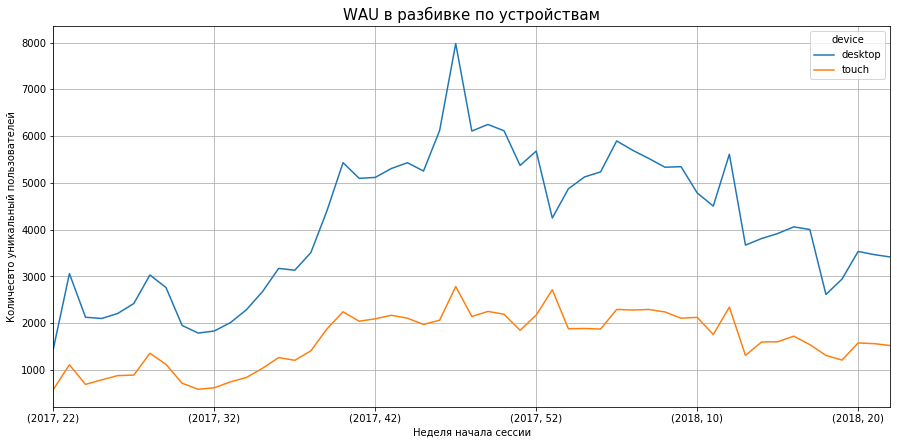

In [28]:
#WAU по источникам
visits.pivot_table(index = ['session_year', 'session_week'], 
                   columns = 'device', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15,7), grid = True)
plt.title('WAU в разбивке по устройствам', size = 15)
plt.xlabel('Неделя начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

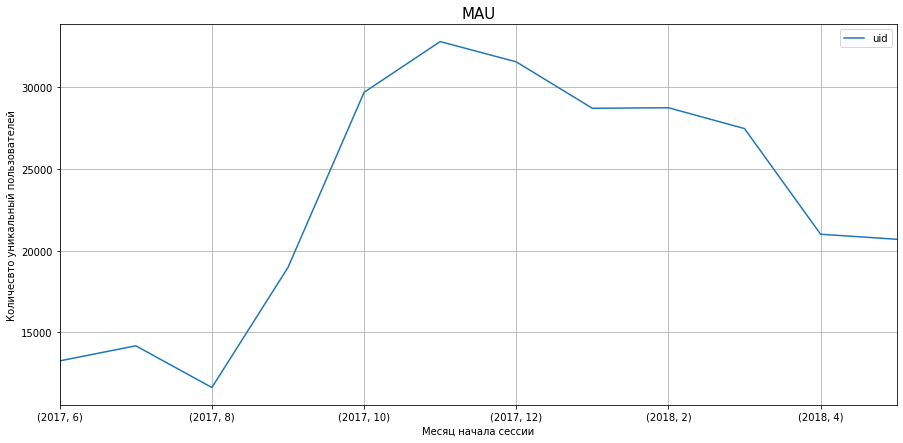

In [29]:
#MAU
visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).plot(figsize = (15,7), grid = True)
plt.title('MAU', size = 15)
plt.xlabel('Месяц начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

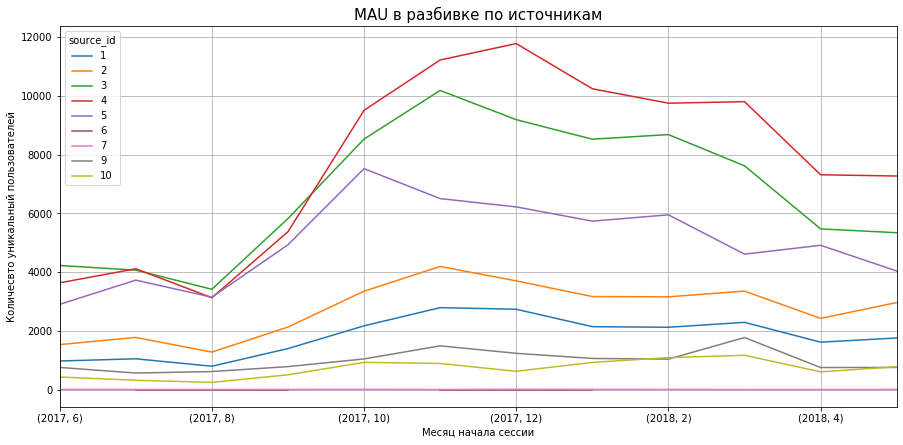

In [30]:
#MAU по источникам
visits.pivot_table(index = ['session_year', 'session_month'], 
                   columns = 'source_id', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15,7), grid = True)
plt.title('MAU в разбивке по источникам', size = 15)
plt.xlabel('Месяц начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

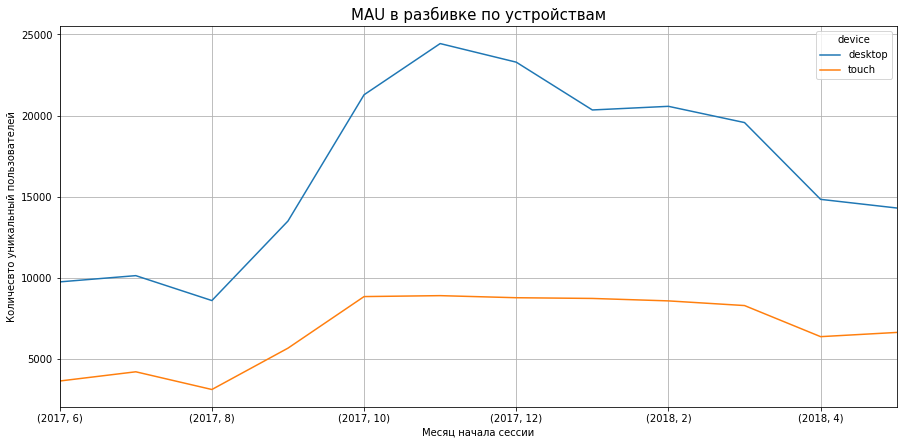

In [31]:
#MAU по устройствам
visits.pivot_table(index = ['session_year', 'session_month'], 
                   columns = 'device', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize = (15,7), grid = True)
plt.title('MAU в разбивке по устройствам', size = 15)
plt.xlabel('Месяц начала сессии')
plt.ylabel('Количесвто уникальный пользователей')
plt.show()

Метрики позволяют узнать, сколько в среднем за выбранный период пользователей пользовалось сервисом. На основании этих метрик не о чем делать выводы, так как неясно, что делали пользователи дальше — отваливались или вовлекались? 

Но можно отметить, что начиная с августа 2017 сервис стал привлекать больше уникальных пользователей. 
Также в ноябре 2017 случился явный всплеск интереса. Может быть это была черная пятница?
В конце марта 2018 был провал по всем источникам и устройствам, возможно, сервис был недоступен для пользоателей.

Зато по данным в разбивке по источникам и устройствам можно судить, что в через десктопную версию приходят чаще, а самые популярные источники траффика — 2, 3, 5.

«Sticky Factor» показывает, с какой вероятностью новый привлеченный пользователь останется в продукте, насколько хорошо продукт удерживает и «цепляет» пользователей. В нашем случае sticky factor 16% (неделя) и 4% (месяц). Кажется, что пользователи не сильно "прилипают" к сервису. 
Например, для игр данный показатель в среднем составляет 18% (<a href="https://app2top.ru/marketing/devtodev-regulyarnost-vhodov-vazhnejshij-pokazatel-monetizatsii-igry-55693.html">источник</a>).

### 2.1.2. Количество сессий в день <a id="header_2_1_2"></a>

In [32]:
#среднее количество сессий в месяц на одного пользователя
sessions_per_user = visits.groupby(['session_year', 'session_month']).agg({'uid':['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['session_per_user'] = sessions_per_user['n_sessions']/sessions_per_user['n_users']
sessions_per_user['session_per_user'].mean()

1.2808894945992668

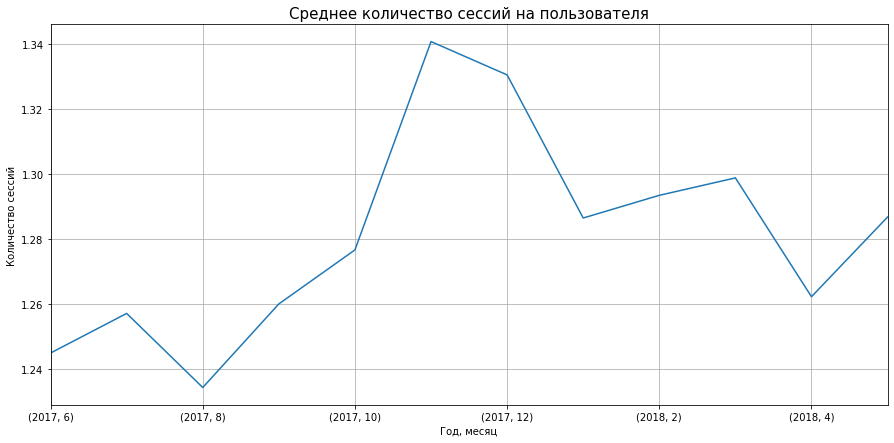

In [33]:
sessions_per_user['session_per_user'].plot(figsize = (15, 7), grid = True)
plt.title('Среднее количество сессий на пользователя', size = 15)
plt.xlabel('Год, месяц')
plt.ylabel('Количество сессий')
plt.show()

На одного пользователя приходится чуть больше 1 сессии. Пик также пришелся на ноябрь 2017 года.

### 2.1.3. Продолжительность сессии <a id="header_2_1_3"></a>

Расчитаем среднюю продолжительность сессии (ASL)

In [34]:
#длительность сессии в секундах
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration'].mean()

643.506488592098

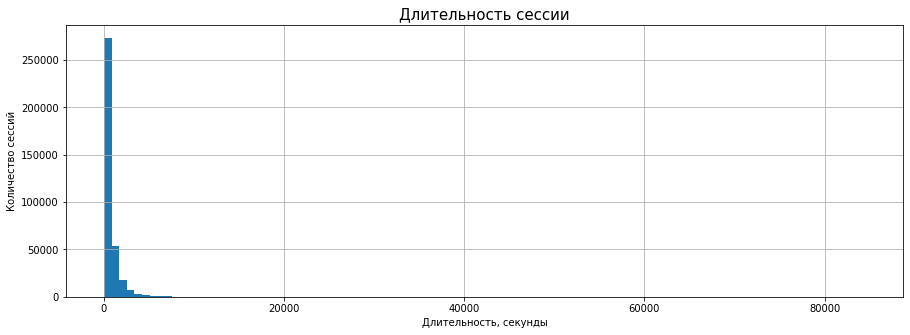

In [35]:
visits['session_duration'].hist(bins=100, figsize = (15, 5))
plt.title('Длительность сессии', size = 15)
plt.xlabel('Длительность, секунды')
plt.ylabel('Количество сессий')
plt.show()

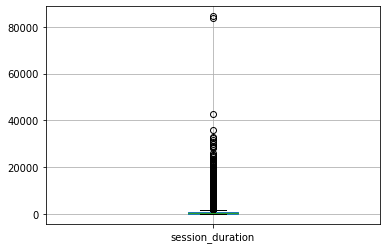

In [36]:
visits.boxplot('session_duration')

Распределение не является нормальным, поэтому стоит смотреть не среднее значение, а другие меры центральной тенденции (моду, медиану, квартили).

In [37]:
visits['session_duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration, dtype: float64

Хотя среднее значение длительности сессии при рассмотрении по всем пользователям около 10 минут, чаще пользователи проводят за использованием сервиса около 5 минут. Присутствуют сессии длительностью 0 секунд и сессия длиниой почти сутки. Мы не будем считать такие сессии выбросом, так как в целом это возможно. 

### 2.1.4. Возвращаемость <a id="header_2_1_4"></a>

Рассчитаем Retention rate (коэффициент удержания).
Датой первого взаимодействия с системой будем считать первую сессию по данным датасета. 

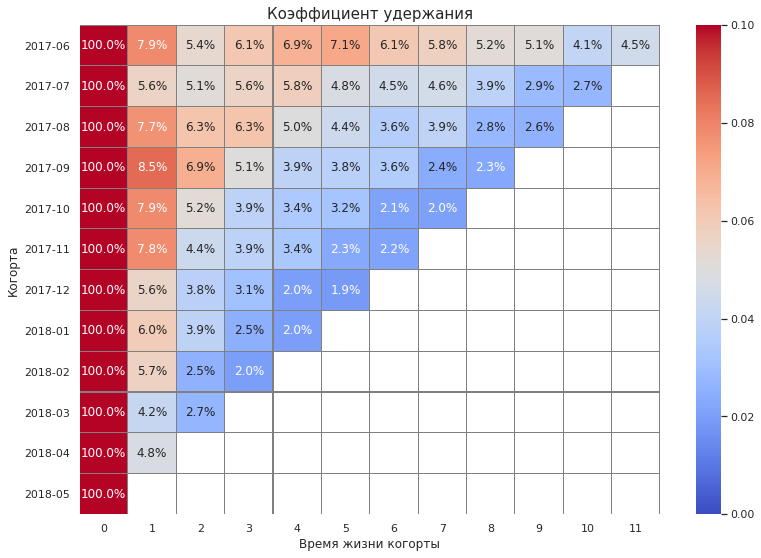

In [38]:
#вычисляем дату первого взаимодействия с системой и добавляем в датасет
first_activity_date = visits.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid') 

#вычисляем месяц активности для каждой сессии и месяц первой сессии
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]') 

#внутри каждой когорты считаем количество уникальных активных пользователей этой когорты для каждого следующего месяца
cohorts = visits.groupby(['first_activity_month','activity_month']).agg({'uid':'nunique'})

#определяем lifetime 
cohorts = cohorts.reset_index()
cohorts['cohort_lifetime'] = cohorts['activity_month'] - cohorts['first_activity_month']
cohorts['cohort_lifetime'] = cohorts['cohort_lifetime']/np.timedelta64(1,'M')
cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'].round().astype('int')

#считаем количество пользователей на нулевой лайфтайм
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users_cnt'}) 
cohorts = cohorts.merge(initial_users_count, on='first_activity_month') 
cohorts = cohorts.rename(columns={'uid':'active_users_cnt'}) 

#вычисляем retention rate
cohorts['retention'] = cohorts['active_users_cnt']/cohorts['cohort_users_cnt'] 
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum') 

#строим heatmap
sns.set(style='white')
plt.figure(figsize=(13, 9))

sns.heatmap(retention_pivot, 
            annot=True, fmt='.1%', 
            linewidths=0.1, 
            linecolor='grey', 
            vmin=0, 
            vmax=0.1, 
            cmap = 'coolwarm',
            yticklabels=retention_pivot.index.strftime('%Y-%m')
           ) 

plt.title('Коэффициент удержания', size = 15)
plt.xlabel('Время жизни когорты')
plt.ylabel('Когорта')
plt.show()

Retention Rate в первый месяц убывает по когортам с течением времени. Для когорты пользователей, пришедших в июне 2017 Retention Rate в первый месяц составляет 7,9%, а для пользователей, пришедших в апреле 2018 года — 4.8 %. Меньше, чем за год, коэффициент удержания упал на 3%. Это говорит о том, что с каждой новой когортой поведение покупателей меняется. При этом он не убывает равномерно: для сентябрьской когорты 2017 года retention rate первого месяца составляет 8.5%. Это наивысший показатель за исследуемое время. 

Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки.

Также судя по появлению на тепловой карте диагоналей, в сервисе произошли изменения, которые одинаково повлияли на всех пользователей вне зависимости от принадлежности к когорте. Изменения начали проявлять влияние в феврале 2018, но особенно заметно влияние в мае 2018. Влияние незначительно только для самой старой когорты и для новых.  


## 2.2. Продажи  <a id="header_2_2"></a>

In [39]:
orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_year'] = orders['buy_ts'].dt.year
orders['buy_month'] = orders['buy_ts'].dt.month
orders['buy_week'] = orders['buy_ts'].dt.week

#вычисляем дату первой покупки 
first_order_date = orders.groupby(['uid'])['buy_date'].min()
first_order_date.name = 'first_order_date'
orders = orders.join(first_order_date, on='uid') 

orders['order_month'] = orders['buy_date'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]') 

### 2.2.1. Момент совершения первой покупки (Когда люди начинают покупать?) <a id="header_2_2_1"></a>

Определим, сколько проходит дней с момента первой активности пользователя в сервисе до момента совершения покупки. Рассматривать будем только тех, кто покупку действительно совершил. Построим гистрограмму, изучим распределение и найдем средний показатель.

In [40]:
#выбираем инфо о первой сессии, первой покупке и объединяем таблицы
users_first_session = visits.groupby('uid').agg({'start_ts': 'min'})
users_first_order = orders.groupby('uid').agg({'buy_ts':'min'})
first_order = users_first_session.merge(users_first_order, on = 'uid').reset_index()
#находим время до первой покупки в секундах
first_order['time_to_buy'] = (first_order['buy_ts'] - first_order['start_ts']).dt.seconds

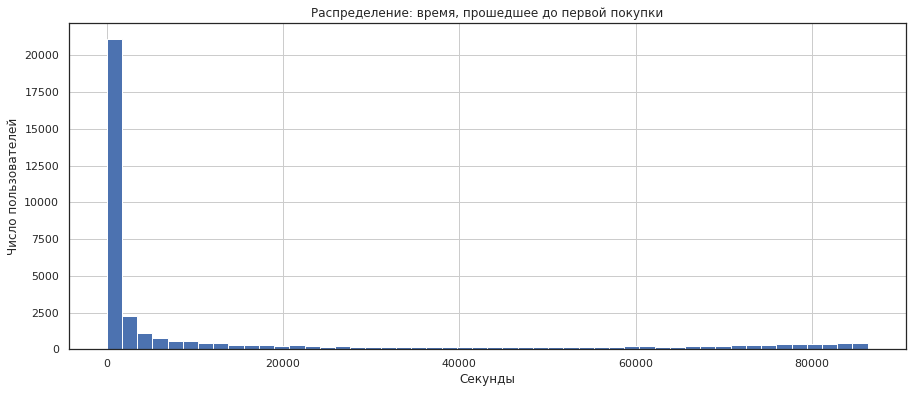

In [41]:
first_order['time_to_buy'].hist(bins = 50, figsize = (15,6))
plt.title('Распределение: время, прошедшее до первой покупки')
plt.xlabel('Секунды')
plt.ylabel('Число пользователей')
plt.show()

In [42]:
first_order['time_to_buy'].mean()

14949.881444569175

При таком распределнии, далеком от нормального, мерой центральной тенденции стоит выбрать медиану или моду. 

In [43]:
first_order['time_to_buy'].median()

960.0

In [44]:
first_order['time_to_buy'].describe()

count    36523.000000
mean     14949.881445
std      25784.567076
min          0.000000
25%        240.000000
50%        960.000000
75%      15120.000000
max      86340.000000
Name: time_to_buy, dtype: float64

Пользователи как правило совершают первую покупку в момент своего первого посещения, в течение 15 минут.

### 2.2.2. Количество совершенных покупок за период (Сколько раз покупают за период?) <a id="header_2_2_2"></a>

In [45]:
#определяем первый источник для каждого пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

#добавляем инфо о первом источнике к инфо о заказах
orders = orders.merge(sources, on = 'uid')

#суммарные продажи по всем устройствам/источникам
report = orders.groupby(['buy_year', 'buy_month']).agg({'uid':'count'})
report = report.reset_index()
report = report.rename(columns = {'uid':'orders_count'})
report.style.background_gradient(cmap='Blues', subset = 'orders_count')

,buy_year,buy_month,orders_count
0,2017,6,2354
1,2017,7,2363
2,2017,8,1807
3,2017,9,3387
4,2017,10,5679
5,2017,11,5659
6,2017,12,6218
7,2018,1,4721
8,2018,2,5281
9,2018,3,5326


In [46]:
#суммарные продажи в разбивке источникам
report = orders.groupby(['buy_year', 'buy_month', 'source_id']).agg({'uid':'count'})
report = report.reset_index()
report = report.rename(columns = {'uid':'orders_count'})
report.style.background_gradient(cmap='Blues', subset = 'orders_count')

,buy_year,buy_month,source_id,orders_count
0,2017,6,1,268
1,2017,6,2,281
2,2017,6,3,704
3,2017,6,4,467
4,2017,6,5,447
5,2017,6,9,79
6,2017,6,10,108
7,2017,7,1,261
8,2017,7,2,279
9,2017,7,3,577


Увеличение количества заказов с октября 2017. Самое большое количество заказов в декабре 2017 года. Видно, что с октября 2017 увеличивается число продаж, приходящих с источников 3, 4, 5.

### 2.2.3. Cредний чек <a id="header_2_2_3"></a>

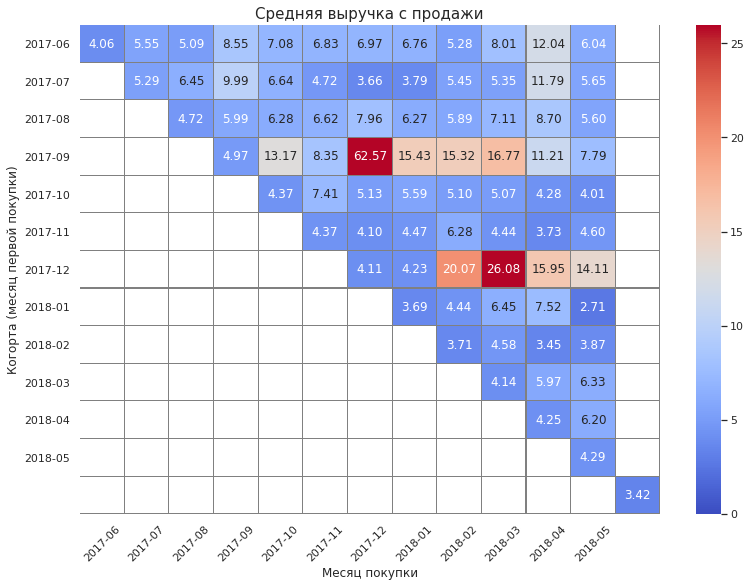

In [47]:
averege_order_pivot = orders.pivot_table(index = 'first_order_month',
                   columns='order_month',
                   values='revenue', 
                   aggfunc='mean') 

plt.figure(figsize=(13, 9))

sns.heatmap(averege_order_pivot, 
            annot=True, 
            fmt='.2f', 
            linewidths=0.1, 
            linecolor='grey', 
            vmin=0, 
            vmax=26, 
            cmap = 'coolwarm',
            yticklabels=retention_pivot.index.strftime('%Y-%m'),
            xticklabels=retention_pivot.index.strftime('%Y-%m')
           ) 

plt.title('Средняя выручка с продажи', size = 15)
plt.xlabel('Месяц покупки')
plt.ylabel('Когорта (месяц первой покупки)')
plt.xticks(rotation=45)
plt.show()

Самый большой показатель по средей выручке с продажи в декабре 2017 — ожидаемо, так как это был месяц с максимальным числом заказов. При этом такой выброс наблюдается только в одной из когорт — сентябрь 2017. И это отлонение от остальных когорт (с постпенным уменьшением) сохраняется в течение 3-4 месяцев. Схожее поведение наблюдается в когорте декабря 2017: средняя выручка максимальна на 4 месяц жизни когорты

Также в двух старших когортах в апреле 2018 есть повышение выручки.

В общем же картина достаточно ровная. Аномалии следует изучить и постараться понять причины.

### 2.2.4. LTV <a id="header_2_2_4"></a>

In [48]:
#число уникальных пользователей в каждой когорте
cohorts_size = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohorts_size.columns = ['first_order_month', 'n_buyers']
cohorts_size.head(10)

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [49]:
#строим когорты: группируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа, суммируем выручку 
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head(10)

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
5,2017-06-01,2017-11-01,1487.92
6,2017-06-01,2017-12-01,1922.74
7,2017-06-01,2018-01-01,1176.56
8,2017-06-01,2018-02-01,1119.15
9,2017-06-01,2018-03-01,1225.51


Строка таблицы cohorts показывает, какую выручку принесла когорта. Например, строка 0 сообщает, что покупатели, сделавшие свой первый заказ в июне 2017 года, в этом же месяце принесли суммарно 9557.49 рублей выручки.

С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц.


In [50]:
ltv_report = pd.merge(cohorts_size, cohorts, on='first_order_month')
ltv_report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


В первых 5 строках значение не изменяется — ведь это продажи одной и той же когорты.
До расчёта LTV осталось 2 шага. Во-первых, LTV считают не из выручки, а из валовой прибыли. Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. Во-вторых, LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.

Маржиналость не задана, поэтому будем считать ее равной 100%. 

In [51]:
margin_rate = 1
    
ltv_report['gp'] = ltv_report['revenue'] * margin_rate
ltv_report['age'] = (ltv_report['order_month'] - ltv_report['first_order_month']) / np.timedelta64(1, 'M')
ltv_report['age'] = ltv_report['age'].round().astype('int')
ltv_report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


In [52]:
ltv_report['ltv'] = ltv_report['gp'] / ltv_report['n_buyers']
    
output = ltv_report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
display(output.fillna(''))

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


Из таблицы видно, сколько в среднем на одного пользователя составляет LTV в каждой когорте в каждый месяц жизни когорты.

Также можем посчитать LTV, рассматривая в качестве когроты — источник. Возраст когорты считаем от первой покупки

In [55]:
#считаем суммарную выручку и возраст когорты
report = orders.groupby(['uid','source_id','first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
report['lifetime'] = ((report['order_month'] - report['first_order_month'])/np.timedelta64(1,'M')).round().astype(int)
report = report.pivot_table(index = 'source_id',
                           columns = 'lifetime',
                           values = 'revenue',
                           aggfunc = 'sum').fillna(0)

#суммарная выручка с одной когорты
report = report.cumsum(axis = 1)
#размер когорты
source_cohorts_size = orders.groupby(['source_id']).agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})

#добавляем размер когорты и делим выручку в каждый месяц жизни на размер когорты 
#div(ltv['cohort_size'], axis = 0) берет столбец cohort_size и делит на него каждый столбец фрейма
report = report.merge(source_cohorts_size, on = 'source_id')
report = report.div(report['cohort_size'], axis = 0).drop(columns = 'cohort_size')
display(report)

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.244695,7.166385,7.953846,8.681828,9.086419,9.339276,9.596816,9.963008,10.291059,10.484905,10.615085,10.724577
2,6.610839,8.028970,9.635428,11.248500,11.949404,12.480901,12.847085,13.044324,13.176392,13.242119,13.354760,13.383802
3,4.488594,4.758397,4.903573,5.002216,5.073268,5.120814,5.147826,5.172679,5.191353,5.198539,5.202970,5.204931
4,4.555284,4.742112,4.837758,4.969371,5.070009,5.180220,5.352530,5.392929,5.411978,5.451280,5.503280,5.506685
5,4.840905,5.093303,5.299071,6.799773,6.998036,7.241711,7.367771,7.454008,7.504846,7.572886,7.586096,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.892509,4.175037,4.452335,4.674706,4.817647,4.945496,5.054072,5.136324,5.267739,5.284972,5.293566,5.293566
10,3.163792,3.228856,3.256298,3.294959,3.312897,3.322897,3.331309,3.343574,3.346102,3.348631,3.348631,3.348631


In [56]:
#для расчетов в следующем разделе
ltv = report.copy()

## 2.3. Маркетинг  <a id="header_2_3"></a>

In [57]:
costs['month'] = costs['dt'].astype('datetime64[M]')

### 2.3.1. Сколько денег потратили? Всего / на каждый источник / по времени <a id="header_2_3_1"></a>

In [58]:
print('За все время потрачено:', costs['costs'].sum())

За все время потрачено: 329131.62


In [59]:
monthly_costs = costs.groupby(['month'])['costs'].sum()
print('Траты за все время в разбивке по месяцам:')
display(monthly_costs.reset_index().style.background_gradient(cmap='Blues', subset = 'costs'))

Траты за все время в разбивке по месяцам:


,month,costs
0,2017-06-01 00:00:00,18015
1,2017-07-01 00:00:00,18240.6
2,2017-08-01 00:00:00,14790.5
3,2017-09-01 00:00:00,24368.9
4,2017-10-01 00:00:00,36322.9
5,2017-11-01 00:00:00,37907.9
6,2017-12-01 00:00:00,38315.3
7,2018-01-01 00:00:00,33518.5
8,2018-02-01 00:00:00,32723
9,2018-03-01 00:00:00,30415.3


In [60]:
source_cost = costs.groupby(['source_id'])['costs'].sum()
print('Траты по каждому источнику за все время:')
display(source_cost.reset_index().style.background_gradient(cmap='Blues', subset = 'costs'))

Траты по каждому источнику за все время:


,source_id,costs
0,1,20833.3
1,2,42806
2,3,141322
3,4,61073.6
4,5,51757.1
5,9,5517.49
6,10,5822.49


In [61]:
costs.pivot_table(index = 'source_id', 
                  columns = 'month', 
                  values = 'costs', 
                  aggfunc = 'sum').style.background_gradient(cmap='Blues')

month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.2,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845,5247.68,4897.8,4157.74,4474.34,3943.14,2993.7,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.2,17025.3,16219.5,14808.8,14228.6,13080.8,9296.81,9411.42
4,3514.8,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.4,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.5,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


Повышенные траты на привлечение соотносятся с увеличением числа заказов с октября 2017. Больше всего трат на источник под номером 3 — безоговорочная победа за все время.

### 2.3.2. Стоимость привлечения одного покупателя из каждого источника <a id="header_2_3_2"></a>

In [62]:
# считаем САС
source_cac = costs.groupby('source_id').agg({'costs': 'sum'}).merge(source_cohorts_size, on = 'source_id')
source_cac['cac'] = source_cac['costs'] / source_cac['cohort_size']
display(source_cac)

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


Самая высокая стоимость привлечения для третьего источника

### 2.3.3. Окупаемость расходов (ROI) <a id="header_2_3_3"></a>

In [63]:
# считаем ROI по источнику
roi = ltv.merge(source_cac[['cac']], on = 'source_id')
roi = roi.div(roi['cac'], axis = 0).drop(columns = 'cac')
roi

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.868964,0.997220,1.106797,1.208097,1.264397,1.299583,1.335420,1.386377,1.432026,1.459000,1.477115,1.492351
2,0.541456,0.657607,0.789183,0.921301,0.978708,1.022240,1.052232,1.068387,1.079204,1.084587,1.093813,1.096191
3,0.332639,0.352633,0.363392,0.370702,0.375968,0.379491,0.381493,0.383335,0.384718,0.385251,0.385579,0.385725
4,0.767946,0.799442,0.815566,0.837754,0.854720,0.873300,0.902348,0.909159,0.912370,0.918996,0.927762,0.928336
5,0.648265,0.682064,0.709620,0.910585,0.937135,0.969766,0.986648,0.998196,1.005004,1.014115,1.015884,1.016750
9,0.767568,0.823280,0.877961,0.921810,0.949997,0.975208,0.996618,1.012837,1.038751,1.042150,1.043844,1.043844
10,0.722145,0.736996,0.743259,0.752084,0.756178,0.758461,0.760381,0.763180,0.763757,0.764335,0.764335,0.764335


Окупаемость для 
- первого источника — третий месяц (2 lifetime). Хотя можно сказать, что расходы почти окупились на второй месяц.
- второго иточника шестой месяц
- пятого на девятый месяц
- девятого на восьмой месяц
- третий, четвертый и десятый источники не окупились еще ни разу

Для того, чтобы рассчитать ROI для когорт, определим CAC для когорт

In [64]:
cac = costs.groupby('month').agg({'costs':'sum'})
cac = cac.reset_index().merge(cohorts_size, left_on = 'month', right_on = 'first_order_month')
cac['cac'] = cac['costs'] / cac['n_buyers']
display(cac)

,month,costs,first_order_month,n_buyers,cac
0,2017-06-01,18015.00,2017-06-01,2023,8.905091
1,2017-07-01,18240.59,2017-07-01,1923,9.485486
2,2017-08-01,14790.54,2017-08-01,1370,10.796015
3,2017-09-01,24368.91,2017-09-01,2581,9.441654
4,2017-10-01,36322.88,2017-10-01,4340,8.369327
5,2017-11-01,37907.88,2017-11-01,4081,9.288870
6,2017-12-01,38315.35,2017-12-01,4383,8.741809
7,2018-01-01,33518.52,2018-01-01,3373,9.937302
8,2018-02-01,32723.03,2018-02-01,3651,8.962758
9,2018-03-01,30415.27,2018-03-01,3533,8.608907


По когортам уже расчитан LTV:

In [65]:
ltv_report.head(10)

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531
5,2017-06-01,2023,2017-11-01,1487.92,1487.92,5,0.735502
6,2017-06-01,2023,2017-12-01,1922.74,1922.74,6,0.950440
7,2017-06-01,2023,2018-01-01,1176.56,1176.56,7,0.581592
8,2017-06-01,2023,2018-02-01,1119.15,1119.15,8,0.553213
9,2017-06-01,2023,2018-03-01,1225.51,1225.51,9,0.605788


In [67]:
# считаем ROI по когорте
roi = ltv_report.merge(cac, on = 'first_order_month')

roi['roi'] = roi['ltv'] / roi['cac']
output = roi.pivot_table(index = 'first_order_month',
               columns = 'age',
               values = 'roi',
               aggfunc = 'mean')

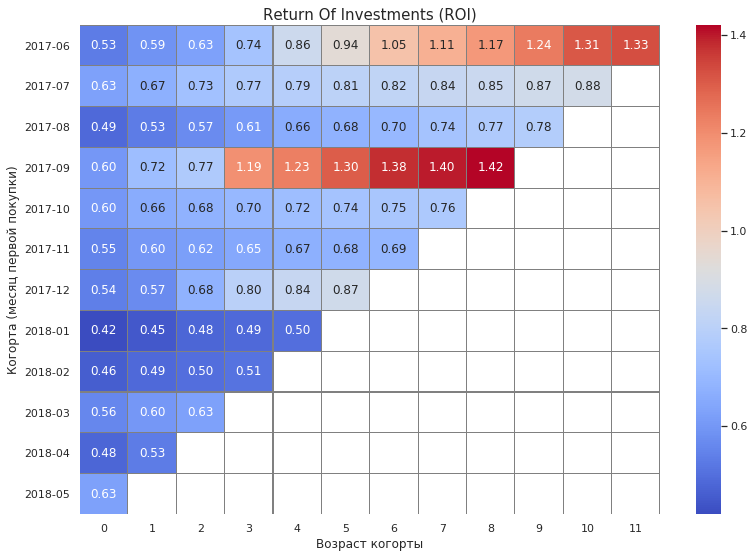

In [68]:
heatmap_output = output.cumsum(axis=1).round(2)

plt.figure(figsize=(13, 9))

sns.heatmap(heatmap_output, 
            annot=True, 
            fmt='.2f', 
            linewidths=0.1, 
            linecolor='grey', 
            #vmin=0, 
            #vmax=26, 
            cmap = 'coolwarm',
            yticklabels=retention_pivot.index.strftime('%Y-%m'),
            #xticklabels=retention_pivot.index.strftime('%Y-%m')
           ) 

plt.title('Return Of Investments (ROI)', size = 15)
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта (месяц первой покупки)')

plt.show()

Окупилась только самая старшая когорта и когорта, с которой была самая большая выручка за все время (сентябрь 2017).

# 3. Вывод <a id="header_3"></a>


DAU/WAU/MAU показали, что начиная с августа 2017 сервис стал привлекать больше уникальных пользователей. 
Также в ноябре 2017 случился явный всплеск интереса.
Через десктопную версию приходят чаще, а самые популярные источники траффика — 2, 3, 5.
На одного пользователя приходится чуть больше 1 сессии.
Пользователи проводят за использованием сервиса около 5 минут, а первую покупку совершают в среднем через 15 минут после первого посещения.  

**Retention Rate** в первый месяц убывает по когортам с течением времени. Меньше, чем за год, коэффициент удержания упал на 3%. Это говорит о том, что с каждой новой когортой поведение покупателей меняется. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки. 
При этом он не убывает равномерно: для сентябрьской когорты 2017 года retention rate первого месяца составляет 8.5%. Это наивысший показатель за исследуемое время. 


В сервисе произошли изменения, которые одинаково повлияли на всех пользователей вне зависимости от принадлежности к когорте. Изменения начали проявляться в феврале 2018, но особенно заметно влияние в мае 2018. Влияние незначительно только для самой старой когорты и для новых. 


Увеличение **числа заказов** с октября 2017. Самое большое количество заказов в декабре 2017 года. С октября 2017 увеличивается число продаж, приходящих с источников 3, 4, 5.

Самый большой показатель по **средей выручке** с продажи в декабре 2017 — ожидаемо, так как это был месяц с максимальным числом заказов. При этом такой выброс наблюдается только в одной из когорт — сентябрь 2017. И это отклонение от остальных когорт (с постпенным уменьшением) сохраняется в течение 3-4 месяцев. Схожее поведение наблюдается в когорте декабря 2017.
Также в двух старших когортах в апреле 2018 есть повышение выручки.

Повышенные траты на привлечение соотносятся с увеличением числа заказов с октября 2017. Больше всего трат на источник под номером 3 — безоговорочная победа за все время. Для него же самая высокая стоимость привлечения покупалетеля (CAC).

Окупаемость для 
- первого источника — третий месяц (2 lifetime). Хотя можно сказать, что расходы почти окупились на второй месяц.
- второго иточника шестой месяц
- пятого на девятый месяц
- девятого на восьмой месяц
- третий, четвертый и десятый источники не окупились еще ни разу

С одной стороны десктопные пользователи приходят чаще. Но точка роста может быть как раз в touch пользователях.  
Затраты на третий и четвертый источник не окупаются, несмотря на увеличение числа заказов. 

Зная информацию, указанную выше, можно провести ретроспективное исследование и понять, какие в каждый момент времени проводились маркетинговые активности, оценить их влияние и возможность применять их в будущем. 